# Code for Generating and Solving FIE

# Installing Packages

In [1]:
import sys
sys.path.append(r"/home/kimjosy/LocReg_Regularization-1/")
import numpy as np
import matplotlib.pyplot as plt
from regu.csvd import csvd
from regu.discrep import discrep
from regu.l_curve import l_curve
from regu.gcv import gcv
from regu.tikhonov import tikhonov
# from Utilities_functions.tikhonov_vec import tikhonov_vec
from Utilities_functions.discrep_L2 import discrep_L2

# Assembling the kernel matrix (G)

In [6]:
#Assemble the G matrix; (modifications for your project will probably come here)
#Generate the TE values or t values
TE = np.arange(1,512,4).T
#Generate the T2 or s values
T2 = np.arange(1,201).T
#Generate G_matrix
G = np.zeros((len(TE),len(T2)))
#For every column in each row, fill in the e^(-TE(i))
for i in range(len(TE)):
    for j in range(len(T2)):
        G[i,j] = np.exp(-TE[i]/T2[j])

#I choose the discretized Laplace kernel

# Defining some Ground Truth Solution

In [7]:
#Create ground truth solution

#sigmas represent the std deviations
#mus represent the averages/mean along the T2 axis
sigma1 = 3
mu1 = 40
sigma2 = 6
mu2 = 90

#Create ground truth
# One simple way is to generate a bimodal normal distribution 
g = (1 / (np.sqrt(2 * np.pi) * sigma1)) * np.exp(-((T2 - mu1) ** 2) / (2 * sigma1 ** 2))
g = g + (1 / (np.sqrt(2 * np.pi) * sigma2)) * np.exp(-((T2 - mu2) ** 2) / (2 * sigma2 ** 2))
g = g/2


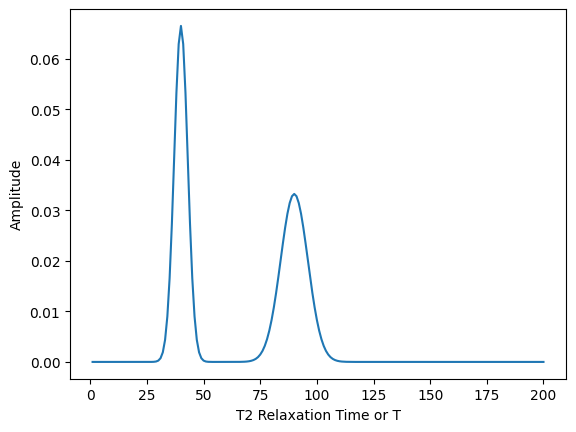

In [8]:
#Lets Plot the Ground Truth Solution
plt.plot(T2, g, label = "Ground Truth Solution")
plt.xlabel("T2 Relaxation Time or T")
plt.ylabel("Amplitude")
plt.show()

# Generating Noisy Data given SNR; Polluting the Ground Truth

In [9]:
data_noiseless = np.dot(G, g)
SNR = 1000
SD_noise = 1 / SNR
noise = np.random.normal(0, SD_noise, size=data_noiseless.shape)
data_noisy = data_noiseless + noise

# Selecting the Regularization Term (Lambda) with no constraints on the solution using DP (discrepancy principle)

In [10]:
#One Example is using the Discrepancy Principle (DP)
#First decompose G using SVD:
U,s,V = csvd(G,tst = None, nargin = 1, nargout = 3)

#Find the delta with a safety factor of 1.05
delta = np.linalg.norm(noise)*1.05

#Select a lambda using the discrepancy principle given some delta
_,lambda_DP = discrep(U,s,V,data_noisy,delta, x_0= None, nargin = 5)
f_rec_DP,_,_ = tikhonov(U,s,V,data_noisy,lambda_DP, nargin=5, nargout=1)

# Selecting the Regularization Term (Lambda) with no constraints on the solution using LC (LCurve)

In [11]:
lambda_LC,rho,eta,_ = l_curve(U,s,data_noisy, method = None, L = None, V = None, nargin = 3, nargout = 3)
f_rec_LC,_,_ = tikhonov(U,s,V,data_noisy,lambda_LC, nargin=5, nargout=1)

# Selecting the Regularization Term (Lambda) with no constraints on the solution using GCV (Generalized Cross VAlidation)

In [12]:
lambda_GCV,_,reg_param = gcv(U,s,data_noisy, method = 'Tikh', nargin = 3, nargout = 3)
f_rec_GCV,_,_ = tikhonov(U,s,V,data_noisy,lambda_GCV, nargin=5, nargout=1)

# Generating the Solution with the Regularization Term (Lambda) with L2 Penalty

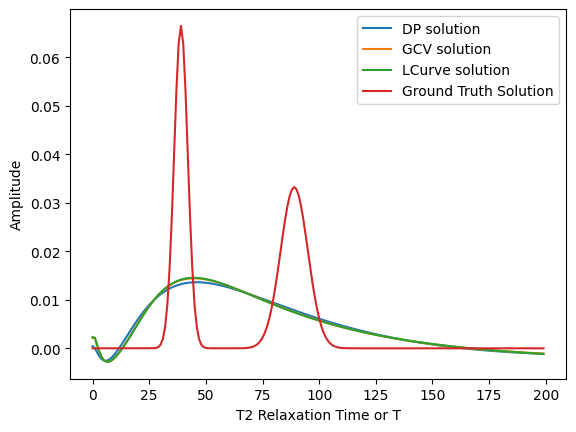

In [13]:
#Lets plot the solution and compare to ground truth
plt.plot(f_rec_DP, label = "DP solution")
plt.plot(f_rec_GCV, label = "GCV solution")
plt.plot(f_rec_LC, label = "LCurve solution")
plt.plot(g, label = "Ground Truth Solution")
plt.xlabel("T2 Relaxation Time or T")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Selecting the Regularization Term (Lambda) and Generating Solution with non-negativity constraint using L2 Penalty

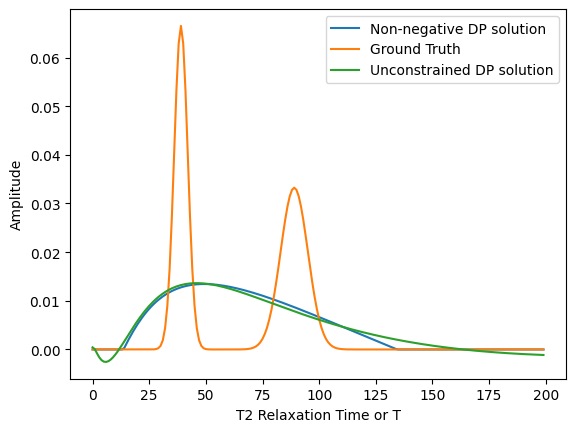

In [14]:
#Reshape Lambda as a vector
Lambda = np.ones(len(T2)) * lambda_DP
Lambda = Lambda.reshape(-1,1)

non_negsol, lambda_DP = discrep_L2(data_noisy, G, SNR, Lambda)
plt.plot(non_negsol, label = "Non-negative DP solution")
plt.plot(g, label = "Ground Truth")
plt.plot(f_rec_DP, label = "Unconstrained DP solution")
plt.xlabel("T2 Relaxation Time or T")
plt.ylabel("Amplitude")
plt.legend()
plt.show()